# TensorFlow Wide & Deep Learning Tutorial

使用tf.learnAPI共同的训练一个宽度线性模型和深度前向反馈神经网络。这种方法结合了记忆和泛化的优势。这对于一般的大型的，有着稀疏输入特征（例如类别特征，有着大量可能特征值）的回归和分类问题是有用的。如果你对学习更多的关于宽度&深度学习是如何工作有兴趣，请点击research paper（https://arxiv.org/abs/1606.07792 ）

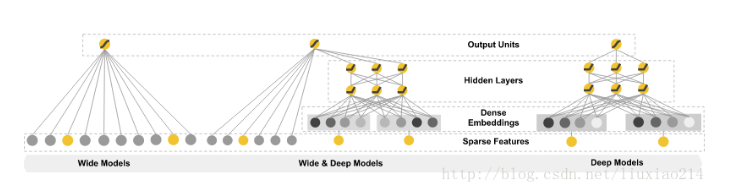

上图展示了宽度模型（有着稀疏特征和转换的逻辑回归）、深度模型（有着嵌入层和多个隐藏层的前向反馈神经网络）和宽度&深度模型（两个结合的共同训练）的对比。在高层，使用tf.learnAPI，只需要三步来配置宽度、深度、宽度&深度模型。

1、选择宽度部分的特征：选择你想使用的稀疏基列和交叉列。  
2、选择深度部分的特征：选择连序列、对每一个类别列的嵌入维度和隐藏层大小  
3、将他们放在一起组成宽度&深度模型（DNNLinearCombinedClassifier）。  


In [57]:
# 导库
#从python2.1开始以后, 当一个新的语言特性首次出现在发行版中时候, 如果该新特性与以前旧版本python不兼容, 则该特性将会被默认禁用. 如果想启用这个新特性, 则必须使用 "from __future__import *" 语句进行导入.
from __future__ import absolute_import#加入绝对引入这个新特性，引入系统的标准
from __future__ import division#导入python未来支持的语言特征division(精确除法)
from __future__ import print_function #即使在python2.X，使用print就得像python3.X那样加括号使用

import argparse#Argparse的作用就是为py文件封装好可以选择的参数，使他们更加灵活，丰富。
import sys
import tempfile#import tempfile

from six.moves import urllib#six.moves下的urllib中的函数，用于下载

import pandas as pd
import tensorflow as tf

In [58]:
#参数封装状态
#此部分.py中可以再命令行部分添加参数
#https://www.cnblogs.com/xlqtlhx/p/8243592.html
#if __name__ == "main":
parser = argparse.ArgumentParser()#创建解析器对象ArgumentParser，可以添加参数。
parser.register("type", "bool", lambda v: v.lower() == "true")
#add_argument:读入命令行参数，该调用有多个参数
parser.add_argument(
    #模型文件
    "--model_dir",
    type=str,
    default="./wdl_data/model_save",
    help="Base directory for output models."
)
parser.add_argument(
    #模型类型
    "--model_type",
    type=str,
    default="wide_n_deep",
    help="Valid model types: {'wide', 'deep', 'wide_n_deep'}."
)
parser.add_argument(
    #训练步长
    "--train_steps",
    type=int,
    default=2000,
    help="Number of training steps."
)
parser.add_argument(
    #训练数据地址
    "--train_data",
    type=str,
    default="./wdl_data/adult.data",
    help="Path to the training data."
)
parser.add_argument(
    #测试数据地址
    "--test_data",
    type=str,
    default="./wdl_data/adult.test",
    help="Path to the test data."
)
#dd_argumen()第一个是选项，第二个是数据类型，第三个默认值，第四个是help命令时的说明
FLAGS = None
FLAGS, unparsed = parser.parse_known_args()

In [59]:
FLAGS#使用的参数

Namespace(model_dir='./wdl_data/model_save', model_type='wide_n_deep', test_data='./wdl_data/adult.test', train_data='./wdl_data/adult.data', train_steps=2000)

In [60]:
unparsed#多余的参数为空，没有介绍到多余的命令行参数

['-f',
 'C:\\Users\\tree\\AppData\\Roaming\\jupyter\\runtime\\kernel-9df5ace9-d863-4217-84e3-2102b34c6d1c.json']

In [61]:
model_dir, model_type, train_steps, train_data, test_data = FLAGS.model_dir, FLAGS.model_type, FLAGS.train_steps,\
                   FLAGS.train_data, FLAGS.test_data

In [62]:
# define the column names for the data sets.
COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race","gender",
    "capital_gain","capital_loss","hours_per_week","native_country",
    "income_bracket"
]
LABEL_COLUMN = 'label'
CATEGORICAL_COLUMNS = [
    "workclass","education","marital_status","occupation",
    "relationship","race","gender","native_country"
]
CONTINUOUS_COLUMNS = [
    "age", "education_num","capital_gain","capital_loss",
    "hours_per_week"
]

In [63]:
#下载数据
def maybe_download(train_data, test_data):

    """Maybe downloads training data and returns train and test file names."""
    if train_data:
      train_file_name = train_data
    else:
      train_file = tempfile.NamedTemporaryFile(delete=False)
      urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data", train_file.name)  # pylint: disable=line-too-long
      train_file_name = train_file.name
      train_file.close()
      print("Training data is downloaded to %s" % train_file_name)

    if test_data:
      test_file_name = test_data
    else:
      test_file = tempfile.NamedTemporaryFile(delete=False)
      urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test", test_file.name)  # pylint: disable=line-too-long
      test_file_name = test_file.name
      test_file.close()
      print("Test data is downloaded to %s" % test_file_name)

    return train_file_name, test_file_name

In [64]:
train_file_name, test_file_name = maybe_download(train_data, test_data)

In [65]:
#下载下来的文件名称
train_file_name,test_file_name

('./wdl_data/adult.data', './wdl_data/adult.test')

In [66]:
#训练 与 测试数据的读取与简单处理
df_train = pd.read_csv(
    tf.gfile.Open(train_file_name),
    names=COLUMNS,
    skipinitialspace=True,
    engine="python")
df_test = pd.read_csv(
    tf.gfile.Open(test_file_name),
    names=COLUMNS,
    skipinitialspace=True,
    skiprows=1,
    engine="python")

# remove NaN elements
df_train = df_train.dropna(how='any', axis=0) #删除缺失的值。
#any’ : 
#If any NA values are present, drop that row or column.
df_test = df_test.dropna(how='any', axis=0)

In [67]:
#将训练集和测试集的label设为由income_bracket决定的
df_train[LABEL_COLUMN] = (
    df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test[LABEL_COLUMN] = (
    df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [68]:
df_train.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [69]:
model_dir = tempfile.mkdtemp() if not model_dir else model_dir#如果model_dir存在，则创建一个model_dir 
print("model directory = %s" % model_dir)

model directory = ./wdl_data/model_save


In [70]:
#建立模型
def build_estimator(model_dir, model_type):
    """Build an estimator."""
    
    #没有那么多类别（例如 Sex 或 Embarked（S，Q 或 C））的列，我们根据类名将它们转换为稀疏列。（sparse_column_with_keys）
    # Sparse base columns.
    #CATEGORICAL特征hash
    gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender",
                                                       keys=["female", "male"])
    #使用键创建_SparseColumn，column_name：定义稀疏列名称的字符串
    #返回A _SparseColumnKeys with keys configuration.
    
    #对于类别较多的分类列，由于我们没有一个词汇表文件（vocab file）将所有可能的类别映射为一个整数，所以我们使用哈希值作为键值。
    education = tf.contrib.layers.sparse_column_with_hash_bucket(
        "education", hash_bucket_size=1000)
    #Creates a _SparseColumn with hashed bucket configuration.
    #hash_bucket_size: An int that is > 1. The number of buckets.哈希桶存放HashKey相同的(Key, Value)
    relationship = tf.contrib.layers.sparse_column_with_hash_bucket(
        "relationship", hash_bucket_size=100)
    workclass = tf.contrib.layers.sparse_column_with_hash_bucket(
        "workclass", hash_bucket_size=100)
    occupation = tf.contrib.layers.sparse_column_with_hash_bucket(
        "occupation", hash_bucket_size=1000)
    native_country = tf.contrib.layers.sparse_column_with_hash_bucket(
        "native_country", hash_bucket_size=1000)
    #return A _SparseColumn with hashed bucket configuration（一列使用散列配置）
    
    #连续列使用的是真实的值。 因为 passengerId 是连续的而不是分类的，并且他们已经是整数的 ID 而不是字符串
    # Continuous base columns.
    age = tf.contrib.layers.real_valued_column("age")
    education_num = tf.contrib.layers.real_valued_column("education_num")
    capital_gain = tf.contrib.layers.real_valued_column("capital_gain")
    capital_loss = tf.contrib.layers.real_valued_column("capital_loss")
    hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")
    
    #根据年龄进行划分根据年龄对乘客进行分类。 桶化（Bucketization ）允许我们找到乘客对应年龄组的生存相关性，而不是将所有年龄作为一个大整体，从而提高我们的准确性
    # Transformations.
    #Creates a _BucketizedColumn for discretizing dense input.为离散化创建一个_BucketizedColumn密集的输入。
    age_buckets = tf.contrib.layers.bucketized_column(age,
                                                      boundaries=[
                                                          18, 25, 30, 35, 40, 45,
                                                          50, 55, 60, 65
                                                      ])
    # boundaries=A list or tuple of floats specifying the boundaries. It has to be sorted.
    
    #定义广度列，直接组合拼接各个特征（CATEGORICAL特征）
    #使用gender, native_country, education, occupation, workclass,relationship, age_buckets,组合
    # Wide columns and deep columns.
    wide_columns = [gender, native_country, education, occupation, workclass,
                    relationship, age_buckets,
                    
                    #[education, occupation]#使用特征交叉函数crossed_column
                    #crossed_columna函数Creates a _CrossedColumn for performing feature crosses.
                    #返回一个A _CrossedColumn.
                    tf.contrib.layers.crossed_column([education, occupation],
                                                     hash_bucket_size=int(1e4)),
                    tf.contrib.layers.crossed_column(
                        [age_buckets, education, occupation],
                        hash_bucket_size=int(1e6)),
                    tf.contrib.layers.crossed_column([native_country, occupation],
                                                     hash_bucket_size=int(1e4))]
    #定义深度列，一部分将其embedding
    #一部分数值形直接输入
    deep_columns = [
        tf.contrib.layers.embedding_column(workclass, dimension=8),
        tf.contrib.layers.embedding_column(education, dimension=8),
        tf.contrib.layers.embedding_column(gender, dimension=8),
        tf.contrib.layers.embedding_column(relationship, dimension=8),
        tf.contrib.layers.embedding_column(native_country,
                                           dimension=8),
        tf.contrib.layers.embedding_column(occupation, dimension=8),
        age,
        education_num,
        capital_gain,
        capital_loss,
        hours_per_week,
    ]
    
    #model类型选择
    if model_type == "wide":
        #广度模型直接学习一个线性分类模型
      m = tf.contrib.learn.LinearClassifier(model_dir=model_dir,
                                            feature_columns=wide_columns)
    elif model_type == "deep":
        #深度模型学习一个深层次的DNN分类模型，隐藏层设定为hidden_units=[100, 50
      m = tf.contrib.learn.DNNClassifier(model_dir=model_dir,
                                         feature_columns=deep_columns,
                                         hidden_units=[100, 50])
    else:
        #DNN线性连接分类模型，组合分类器
        #分别输入线性特征和dnn特征，dnn部分所用影响层设定
      m = tf.contrib.learn.DNNLinearCombinedClassifier(
          model_dir=model_dir,
          #model_dir：保存模型参数、图形等的目录。这也可用于将检查点从目录加载到估算器中，以继续训练以前保存的模型。
          linear_feature_columns=wide_columns,
          #linear_feature_columns：包含模型线性部分使用的所有特征列的 iterable（迭代）。集合中的所有项目都必须是从 FeatureColumn 派生的类的实例。
          dnn_feature_columns=deep_columns,
          #dnn_feature_columns：包含模型深层部分所使用的所有特征列的 iterable。集合中的所有项目都必须是从 FeatureColumn 派生的类的实例。
          dnn_hidden_units=[100, 50])
    return m
#返回The model_fn with the following signature: def model_fn(features, labels, mode, metrics)

In [71]:
# #为我们的连续和分类列创建映射。 
# 我们先创建一个输入函数给我们的数据框，它能将我们的数据框转换为 Tensorflow 可以操作的对象。
# 这样做的好处是，我们可以改变和调整我们的 tensors 创建过程。 
# 例如说我们可以将特征列传递到.fit .feature .predict作为一个单独创建的列，
# 就像我们上面所描述的一样，但这个是一个更加简洁的方案。
def input_fn(df):
    """Input builder function."""
    #输入df的结构化数据
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    #设定CONTINUOUS_COLUMN的key对应其数值并按照顺序key对应tensor
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    #设定categorical的key对应一个tf.SparseTensor稀疏张量
    categorical_cols = {
        k: tf.SparseTensor(
            indices=[[i, 0] for i in range(df[k].size)],
            values=df[k].values,
            dense_shape=[df[k].size, 1])
        #tf.SparseTensor稀疏张量（自行包装一个张量）
        # indices为 A 2-D int64 tensor of dense_shape [N, ndims]表示稠密张量中非零值的指标
        # values表示稠密张量中的非零值
        #dense_shapeint64的一维张量，表示稠密张量的形状。指定张量的大小
        for k in CATEGORICAL_COLUMNS}
    '''
    categorical_cols = { 
        k: tf.SparseTensor( 
          indices=[[i, 0] for i in range(df[k].size)], 
          values=df[k].values,
          shape=[df[k].size, 1]) 
        for k in CATEGORICAL_COLUMNS}    
    '''
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    #feature_cols特征组合
    # Converts the label column into a constant Tensor.
    label = tf.constant(df[LABEL_COLUMN].values)
    # Returns the feature columns and the label.
    return feature_cols, label

In [72]:
#模型训练
m = build_estimator(model_dir, model_type)
m.fit(input_fn=lambda: input_fn(df_train), steps=train_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './wdl_data/model_save', '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D80C0D5390>, '_task_id': 0, '_session_config': None, '_evaluation_master': '', '_master': '', '_train_distribute': None, '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_log_step_count_steps': 100, '_environment': 'local', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_is_chief': True, '_device_fn': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_task_type': None}
Instructions for updating:
The default behavior of sparse_feature_cross is changing, the default
value for hash_key will change to SPARSE_FEATURE_CROSS_DEFAULT_HASH_KEY.
From that point on sparse_feature_cross will always use FingerprintCat64
to concatenate the fea

DNNLinearCombinedClassifier(params={'input_layer_partitioner': None, 'embedding_lr_multipliers': None, 'dnn_hidden_units': [100, 50], 'dnn_activation_fn': <function relu at 0x000001D877221598>, 'linear_optimizer': None, 'fix_global_step_increment_bug': False, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x000001D80C0D55F8>, 'linear_feature_columns': (_SparseColumnKeys(column_name='gender', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('female', 'male'), num_oov_buckets=0, vocab_size=2, default_value=-1), combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='native_country', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='education', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='occupation', is_integerized=False,

In [73]:
#测试集评估
results = m.evaluate(input_fn=lambda: input_fn(df_test), steps=1)
for key in sorted(results):
  print("%s: %s" % (key, results[key]))
print("Train WDL End")

INFO:tensorflow:Starting evaluation at 2018-12-19-14:23:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./wdl_data/model_save\model.ckpt-14014
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-12-19-14:23:59
INFO:tensorflow:Saving dict for global step 14014: accuracy = 0.8552914, accuracy/baseline_label_mean = 0.23622628, accuracy/threshold_0.500000_mean = 0.8552914, auc = 0.90808505, auc_precision_recall = 0.7733406, global_step = 14014, labels/actual_label_mean = 0.23622628, labels/prediction_mean = 0.23504388, loss = 0.3132117, precision/positive_threshold_0.500000_mean = 0.74298763, recall/positive_threshold_0.500000_mean = 0.5923037
accuracy: 0.8552914
accuracy/baseline_label_mean: 0.23622628
accuracy/threshold_0.500000_mean: 0.8552914
auc: 0.90808505
auc_precision_recall: 0.7733406
global_step: 14014
labels/actual_label_mean: 0.23622628
l